In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

# 1-dim Bayesian inversian
Let $y=x^2 + \varepsilon w$, where $w$ is a standard normal random variable. Suppose $x$ follows a standard normal distribution as prior. Given any $y\in\mathbb{R}$, we wish to recover the posterior distribution $P(x|y)$ using the Metropolis-Hastings algorithm.

In [18]:
f = lambda x: x**2
P = lambda x: np.exp(-x**2/2)/np.sqrt(2*np.pi)
y0 = 10
# y0 = 4
# y0 = 10
epsilon = 0.2

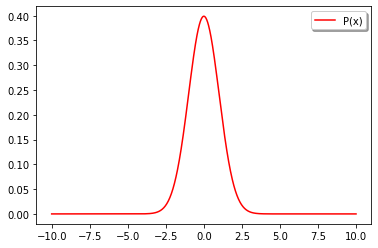

In [19]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

### Metropolis Hastings
For any $P(x)$, the Metropolis-Hastings algorithm proceeds as follows.
* Given some $y_0$, start at some $x_t = x_0$.
* Sample $x_i \sim Q(x|x_t)$
* $A = \min\Big(\frac{\mathcal{L}(y_0,x_i)P(x_i)Q(x_t|x_i)}{\mathcal{L}(y_0,x_t))P(x_t)Q(x_i|x_t)},1\Big)$
* Sample $k_i \sim Uniform[0,1]$
    * if $k_i < A$ then $x_{t+1} = x_i$
    * else $x_{t+1} = x_t$
    
As $t \rightarrow \infty$, $x_t$ comes from a normalized $P(x)$. The Markov chain takes some time to stabilize which is the burn-in phase. In the following code we ignore the first 1000 samples as burn-in.   
Here we choose $Q(x|x_t)$ as $\mathcal{N}(x_t, 1)$ which is actually equal to $Q(x_t|x)$ and should cancel but I have added it in the code for clarity.

In [20]:
Q = lambda t1, t0: np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))
L = lambda y,x: np.exp(-(y-f(x))**2/(2*epsilon**2))
x0 = 0
xt = x0
samples = []
for i in range(1000000):
    xt_candidate = np.random.normal(xt, 1)
    accept_prob = (L(y0,xt_candidate) * P(xt_candidate) * Q(xt, xt_candidate))/(L(y0, xt) * P(xt) * Q(xt_candidate, xt))
    accept_prob = min(1,accept_prob)
    if np.random.uniform(0, 1) < accept_prob:
        xt = xt_candidate
    samples.append(xt)
burn_in = 10000
samples = np.array(samples[burn_in:])

<ipython-input-20-b55c8457a252>:8: RuntimeWarning: invalid value encountered in double_scalars
  accept_prob = (L(y0,xt_candidate) * P(xt_candidate) * Q(xt, xt_candidate))/(L(y0, xt) * P(xt) * Q(xt_candidate, xt))
<ipython-input-20-b55c8457a252>:8: RuntimeWarning: divide by zero encountered in double_scalars
  accept_prob = (L(y0,xt_candidate) * P(xt_candidate) * Q(xt, xt_candidate))/(L(y0, xt) * P(xt) * Q(xt_candidate, xt))


Compute the histogram of samples from Metropolis Hastings and compare it with normalized $P(x)$. It's clear that Metropolis Hastings algorithm generates samples from underlying normalized $P(x)$.

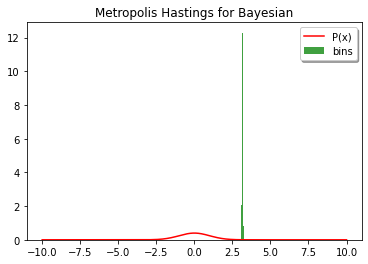

In [21]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, density=1, label='bins')
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.title('Metropolis Hastings for Bayesian')
plt.legend(loc='upper right', shadow=True)
plt.show()

# 2-dim Bayesian inversian

Let $y=|x|^2 + \varepsilon w$ be our underlying problem, where $w$ is a standard normal random variable in $\mathbb{R}^2$. Suppose $x$ follows a standard normal distribution as prior. Given any $y\in\mathbb{R}$, we wish to recover the posterior distribution $\mathbb{P}(x|y)$ using the Metropolis-Hastings algorithm.

In [6]:
def density1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm_sq = z1 ** 2 + z2 ** 2
    u = norm_sq / 2
    return np.exp(-u)

def f(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    f = z1**2 + z2**2
    return f

def q(z,x):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    x = np.reshape(x, [x.shape[0], 2])
    x1, x2 = x[:, 0], x[:, 1]
    p = (z1-x1)**2 + (z2-x2)**2
    return np.exp(-p/2)

def L(y, z, obs_sigma=0.1):
    norm_sq = (y-f(z))**2/(2*obs_sigma**2)
    return np.exp(-norm_sq)

### Plot the prior density

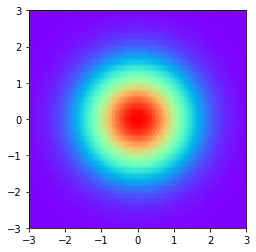

In [7]:
r = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = density1(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

Use MH with multivariate normal as the proposal

In [11]:
def metropolis_hastings(y, prior_density, proposed_density, likelihood, size=2500000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (likelihood(y, xt_candidate) * prior_density(xt_candidate) * proposed_density(xt_candidate,xt))/(likelihood(y, xt) * prior_density(xt) * proposed_density(xt,xt_candidate))
        accept_prob = min(1, accept_prob)
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [12]:
y0 = 1
# y0 = 16
samples = metropolis_hastings(y0, density1, q, L)

100%|██████████████████████████████████████████████████████████████████████| 2510000/2510000 [08:37<00:00, 4849.33it/s]


Plot the histogram of samples

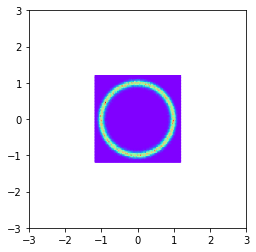

In [13]:
plt.hexbin(samples[:,0], samples[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()